<a href="https://colab.research.google.com/github/VaibhavNagrale007/Natural-Language-Processing/blob/main/Copy_of_classify_text_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basic imports
import pandas as pd
import spacy
import nltk
from nltk.corpus import wordnet
import random
import re
import random
from tqdm import tqdm
import numpy as np

In [ ]:
df_wiki = pd.read_csv('/content/drive/MyDrive/NLP-Project/wiki-cleaned.csv')
df = pd.read_csv('/content/drive/MyDrive/NLP-Project/hydra-cleaned.csv')

In [ ]:
encoding_map = {}
for title in set(df_wiki['Title']):
  encoding_map[title] = len(encoding_map)

In [ ]:
len(encoding_map)

1921

In [ ]:
reverse_encoding_map = {}
for key, value in encoding_map.items():
  reverse_encoding_map[value] = key

In [ ]:
df['labels'] = [encoding_map[title] for title in df['Title']]
df_wiki['labels'] = [encoding_map[title] for title in df_wiki['Title']]

In [ ]:
train_texts, test_texts1,  train_labels, test_labels1,  = df_wiki['Plot'], df['Summary'], df_wiki['labels'], df['labels']

In [ ]:
test_texts2, test_labels2 = df['Short Summary'], df['labels']

In [ ]:
print(f"{len(train_texts)} train texts")
print(f"{len(train_labels)} train labels")
print(f"{len(test_texts1)} test texts 1")
print(f"{len(test_labels1)} test labels 1")
print(f"{len(test_texts2)} test texts 2")
print(f"{len(test_labels2)} test labels 2")

1921 train texts
1921 train labels
1921 test texts 1
1921 test labels 1
1921 test texts 2
1921 test labels 2


In [ ]:
labels_count = 100

In [ ]:
def prune(labels_count, x, y):
  new_x = []
  new_y = []
  for i, j in zip(x, y):
    if j < labels_count:
      new_x.append(i)
      new_y.append(j)
  return new_x, new_y

In [ ]:
train_texts_pruned, train_labels_pruned = prune(labels_count, train_texts, train_labels)
test_texts1_pruned, test_labels1_pruned = prune(labels_count, test_texts1, test_labels1)
test_texts2_pruned, test_labels2_pruned = prune(labels_count, test_texts2, test_labels2)

In [ ]:
[reverse_encoding_map[num] for num in train_labels_pruned]

['What Women Want (2000)',
 'American Pie 2 (2001)',
 'Jeepers Creepers (2001)',
 'Kissing Jessica Stein (2001)',
 'Swordfish (2001)',
 'Below (2002)',
 'Spirit: Stallion of the Cimarron (2002)',
 'Unfaithful (2002)',
 'Basic (2003)',
 'Anchorman: The Legend of Ron Burgundy (2004)',
 'Miracle (2004)',
 'Coach Carter (2005)',
 'Four Brothers (2005)',
 "The Hitchhiker's Guide to the Galaxy (2005)",
 'King Kong (2005)',
 'The Weather Man (2005)',
 'Curious George (2006)',
 'Gridiron Gang (2006)',
 'The Mist (2007)',
 'No Country for Old Men (2007)',
 'TMNT (2007)',
 'Bolt (2008)',
 'Hancock (2008)',
 "Nim's Island (2008)",
 'Angels & Demons (2009)',
 'Brothers (2009)',
 'The Lovely Bones (2009)',
 'The Proposal (2009)',
 'Date Night (2010)',
 'Grown Ups (2010)',
 'Hereafter (2010)',
 'What If... (2010)',
 'Dolphin Tale (2011)',
 'I Am Number Four (2011)',
 'Like Crazy (2011)',
 'Rango (2011)',
 'Sherlock Holmes: A Game of Shadows (2011)',
 'Transformers: Dark of the Moon (2011)',
 'Journe

In [ ]:
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def get_wordnet_pos(tag):
    tag = tag[0].upper()
    tag_dict = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}
    return tag_dict.get(tag, wordnet.NOUN)

def get_synonym(word, pos):
    synsets = list(wordnet.synsets(word, pos=get_wordnet_pos(pos)))
    if synsets:
        synonyms = [lemma.name() for synset in synsets for lemma in synset.lemmas()]
        if synonyms:
            return random.choice(synonyms)
    return word

def paraphrase_token(token):
    if token.ent_type_ != '':
        return get_synonym(token.text, token.pos_)
    elif token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and random.random() < 0.5:
        # Replace nouns, verbs, adjectives, and adverbs with a synonym (50% chance)
        return get_synonym(token.text, token.pos_)
    else:
        return token.text

def paraphrase_sentence(sentence):
    doc = nlp(sentence)
    paraphrased_tokens = [paraphrase_token(token) for token in doc]
    return ' '.join(paraphrased_tokens)

def add_paraphrases(x, y, num_paraphrases, keep_original = True):
  more_x = []
  more_y = []
  for text, label in tqdm(zip(x, y), total=len(x)):
    doc = nlp(str(text))
    sentences = [sent.text for sent in doc.sents]
    for _ in range(num_paraphrases):
        random.shuffle(sentences)  # Shuffle sentences independently for each paraphrase

        reordered_text = ' '.join(sentences)
        paraphrased_text = ' '.join(paraphrase_sentence(sentence) for sentence in sentences)

        # Post-processing
        paraphrased_text = paraphrased_text.replace('_', ' ')  # Remove underscores
        paraphrased_text = re.sub(r'\s+', ' ', paraphrased_text)  # Remove extra spaces
        more_x.append(paraphrased_text)
        more_y.append(label)
  if keep_original:
    more_x.extend(x)
    more_y.extend(y)
  return more_x, more_y

In [ ]:
def remove_capital_words(data, labels):
  new_data = []
  new_labels = []
  for text, label in zip(data, labels):
    words = text.split()
    filtered_words = [word for word in words if not word[0].isupper()]
    new_data.append(" ".join(filtered_words))
    new_labels.append(label)
  return new_data, new_labels

text = ["This is a Sentence with some Capital."]
cleaned_text, cleaned_labels = remove_capital_words(text, [0])
print(cleaned_text, cleaned_labels)

['is a with some'] [0]


In [ ]:
def randomly_remove_and_add_sentences(x, y, num_paragraphs, shuffle_probability = 0.5, probability = None, keep_original = True):
  more_x = []
  more_y = []
  for text, label in tqdm(zip(x, y), total=len(x)):
    doc = nlp(str(text))
    sentences = [str(sent) for sent in doc.sents]
    added = 0
    while added < num_paragraphs:
      para = ""
      if probability is None:
        prob = random.random()
      else:
        prob = probability
      for sentence in sentences:
        if random.random() <= prob:
          para += " " + sentence
      para = para.strip()
      if len(para) != 0:
        more_x.append(para)
        more_y.append(label)
        added += 1
  if keep_original:
    more_x.extend(x)
    more_y.extend(y)
  return more_x, more_y

In [ ]:
#X_train, y_train = add_paraphrases(train_texts_pruned, train_labels_pruned, 2)

100%|██████████| 256/256 [03:38<00:00,  1.17it/s]


In [ ]:
def break_to_two_sentences(x, y):
  more_x = []
  more_y = []
  for text, label in tqdm(zip(x, y), total=len(x)):
    doc = nlp(str(text))
    sentences = [str(sent) for sent in doc.sents]
    groups = [sentences[i:i+2] for i in range(0, len(sentences), 2)]
    for group in groups:
      more_x.append(" ".join(group))
      more_y.append(label)
  return more_x, more_y

In [ ]:
broken_x, broken_y = break_to_two_sentences(train_texts_pruned, train_labels_pruned)
X_train, y_train = remove_capital_words(broken_x, broken_y)
X_train.extend(broken_x)
y_train.extend(broken_y)

100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

47.604862444017904


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
import numpy as np
np.save('x.npy', X_train)
np.save('y.npy', y_train)

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install "tf-models-official==2.13.*"

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-256_A-4'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.9923972  -0.05357219  0.3091848   0.9505573  -0.05440651  0.9988622
 -0.9947893  -0.00854    -0.45510408 -0.08636717  0.83203906 -0.92552644]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.9684545  -1.7037108   1.0094745  ...  0.8407504   0.35471287
  -1.8288119 ]
 [-0.7315013  -0.9106693   0.30870247 ...  1.2626396   0.18190686
  -0.8705797 ]
 [-1.1151164  -1.8587103   1.9688951  ...  0.4747224   1.1492233
  -0.36351836]
 ...
 [-1.02494    -1.7695192   0.36316863 ...  0.35074943  0.18356091
  -0.6765582 ]
 [-0.47082767 -2.0506608   0.2558354  ...  0.8501364   0.18506283
  -0.6660285 ]
 [-0.14080307 -1.867622    0.6415791  ...  0.25832373  0.0461694
  -0.14218213]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(labels_count, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor(
[[0.00244031 0.00387455 0.00341747 0.00153787 0.02822957 0.00459106
  0.02523523 0.00981872 0.02847264 0.0068265  0.00650499 0.03608491
  0.00482025 0.01059069 0.01248833 0.00597394 0.02282323 0.00555511
  0.01095468 0.00470918 0.00647133 0.00742002 0.00164101 0.01069651
  0.00552939 0.00190115 0.02221479 0.00480518 0.00156596 0.05108939
  0.00464371 0.01037881 0.01124073 0.00262916 0.01639803 0.00763103
  0.00942395 0.01557729 0.00930259 0.01749563 0.01664288 0.00842129
  0.00881687 0.0032614  0.00726781 0.0016166  0.00572516 0.00173657
  0.01753099 0.00384012 0.0138459  0.0170049  0.00375485 0.01716037
  0.00715337 0.00981308 0.00290134 0.01149386 0.00259975 0.01501842
  0.00126005 0.00281353 0.01810515 0.01689998 0.01733675 0.01215005
  0.00040291 0.00477342 0.00272604 0.0008614  0.00280804 0.00484575
  0.02028253 0.03410644 0.01107764 0.00716338 0.00744476 0.00912606
  0.00406857 0.00454918 0.00293966 0.00772393 0.00761166 0.0044598
  0.00262812 0.00368664 0.01724659 0.0

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

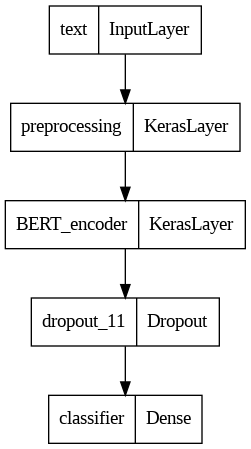

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                           

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.SparseCategoricalAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
# Compile the model with the modified loss and metrics
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

In [ ]:
X_train[0]

"In order to protect Winters' reputation, Coors asks Odell not to tell anyone. Before they leave the ballast tank, Coors dies in a mysterious accident."

In [ ]:
X_train[1]

'Aiming for her, her father instead killed Tom, who is revealed to have been his illegitimate son. Her father then killed himself while Florence watched.'

In [ ]:
type(test_labels1_pruned)

list

In [ ]:
val_x, val_y = remove_capital_words(test_texts1_pruned, test_labels1_pruned)
val_x.extend(test_texts1_pruned)
val_y.extend(test_labels1_pruned)
val_data = (np.array(val_x), np.array(val_y))

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train, validation_data = val_data, epochs=30)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Epoch 1/30
98/98 [==============================] - 162s 2s/step - loss: 4.4042 - sparse_categorical_accuracy: 0.0608 - val_loss: 3.9320 - val_sparse_categorical_accuracy: 0.1900
Epoch 2/30
98/98 [==============================] - 151s 2s/step - loss: 2.8111 - sparse_categorical_accuracy: 0.3564 - val_loss: 2.6666 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/30
98/98 [==============================] - 149s 2s/step - loss: 1.1612 - sparse_categorical_accuracy: 0.7447 - val_loss: 1.8264 - val_sparse_categorical_accuracy: 0.5900
Epoch 4/30
98/98 [==============================] - 158s 2s/step - loss: 0.3265 - sparse_categorical_accuracy: 0.9325 - val_loss: 1.4069 - val_sparse_categorical_accuracy: 0.6800
Epoch 5/30
98/98 [==============================] - 150s 2s/step - loss: 0.0955 - sparse_categorical_accuracy: 0.9878 - val_loss: 1.2004 - val_sparse_categorical_accuracy: 0.7050
Epoch 6/30
98

KeyboardInterrupt: ignored

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
broken_tx, broken_ty = break_to_two_sentences(test_texts1_pruned, test_labels1_pruned)
tx, ty = remove_capital_words(broken_tx, broken_ty)
tx.extend(broken_tx)
ty.extend(broken_ty)

100%|██████████| 100/100 [00:04<00:00, 22.52it/s]

44.8197424892704


In [ ]:
loss, accuracy = classifier_model.evaluate(tx, ty)
print(f'Accuracy: {accuracy}')

15/15 [==============================] - 6s 418ms/step - loss: 2.1060 - sparse_categorical_accuracy: 0.5858
Accuracy: 0.5858368873596191


In [ ]:
loss, accuracy = classifier_model.evaluate(broken_tx, broken_ty)
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 3s 328ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.7597
Accuracy: 0.7596566677093506


In [ ]:
tx, ty = remove_capital_words(broken_tx, broken_ty)

In [ ]:
loss, accuracy = classifier_model.evaluate(tx, ty)
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 6s 757ms/step - loss: 3.1220 - sparse_categorical_accuracy: 0.4120
Accuracy: 0.41201716661453247


In [ ]:
classifier_model.save('/content/drive/MyDrive/NLP-Project/Models/Bert-l2-256-n100')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/NLP-Project/Models/Bert-l2-256-n100')

In [ ]:
loss, accuracy = model.evaluate(tx, ty)
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 5s 519ms/step - loss: 3.1220 - sparse_categorical_accuracy: 0.4120
Accuracy: 0.41201716661453247


In [ ]:
out = model.predict(["""A king got kill"""])
out = out.argmax()
reverse_encoding_map[out]

In [ ]:
out = classifier_model.predict(["""the kingdom is raised by tribal people and one day learns about his royal heritage, his father's bravery in battle and a mission to overthrow the incumbent ruler."""])
out = out.argmax()
reverse_encoding_map[out]
# for i in range(5):
#   print(i, X_train[i])

1/1 [==============================] - 0s 52ms/step


'Shrek 2 (2004)'

In [ ]:
encoding_map['Johnny English Reborn (2011)']

1741

In [ ]:
tx, ty = randomly_remove_and_add_sentences(test_texts1_pruned, test_labels1_pruned, 10, False)

100%|██████████| 256/256 [00:08<00:00, 30.56it/s]


In [ ]:
loss, accuracy = classifier_model.evaluate(tx, ty)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

88/88 [==============================] - 39s 440ms/step - loss: 1.4289 - sparse_categorical_accuracy: 0.7340
Loss: 1.4288878440856934
Accuracy: 0.7340198755264282


In [ ]:
tx[340]

"Following his parents' death in Africa, John Clayton has been be raised by an ape, was known by the name Tarzan, but eventually left Africa and for his parents' home in England, along with the woman he fell in love with and married, Jane Porter. He is asked by Belgian King Leopold to go to Africa to see what he has done there to help the country. But an American, George Washington Williams, wants him to accept so he can accompany him. He says that Leopold might be committing all sorts of atrocities to achieve his goal, like slavery. Clayton agrees and his wife insists that she accompany him because she misses Africa. When they arrive, a man named Rom, who works for Leopold, attacks their village and captures Tarzan and Jane. With Washington's help he escapes and sets out to rescue Jane by going across the jungle."

In [ ]:
test_texts1_pruned[34]

"Following his parents' death in Africa, John Clayton has been be raised by an ape, was known by the name Tarzan, but eventually left Africa and for his parents' home in England, along with the woman he fell in love with and married, Jane Porter. He is asked by Belgian King Leopold to go to Africa to see what he has done there to help the country. Initially, he refuses. But an American, George Washington Williams, wants him to accept so he can accompany him. He says that Leopold might be committing all sorts of atrocities to achieve his goal, like slavery. Clayton agrees and his wife insists that she accompany him because she misses Africa. When they arrive, a man named Rom, who works for Leopold, attacks their village and captures Tarzan and Jane. With Washington's help he escapes and sets out to rescue Jane by going across the jungle. Washington joins him despite being told that he might not make it."

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'sparse_categorical_accuracy'])


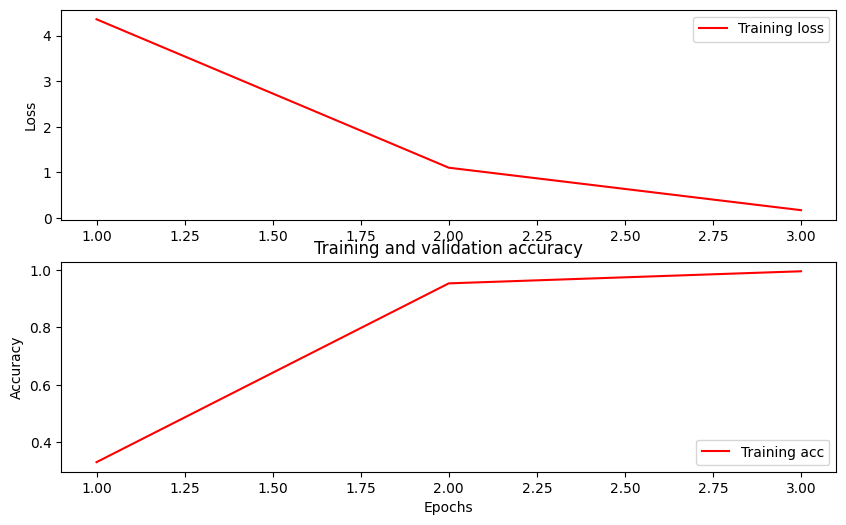

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

2023-12-04 18:01:21.447506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
create_all_paragraphs([["0", "a"], ["1", "b"]])

['0 1', 'a 1', '0 b', 'a b']

In [ ]:
a, b = add_paraphrases(X_train[4:5], y_train[4:5], 5)

100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


In [ ]:
y_train

0       1709
1        169
2        280
3       1014
4        972
        ... 
1916    1369
1917     971
1918    1142
1919     526
1920    1101
Name: labels, Length: 1921, dtype: int64

In [ ]:
a[0]

'The opening sequence takes the form of a computer simulation run by the Devil to analyze souls and determine individual weaknesses to exploit and corrupt. He has no friends and his co-workers are always avoiding him. He has a crush on his colleague, Alison Gardner (Frances O\'Connor), but lacks the courage to ask her out. After Elliot is again ditched by his co-workers at a bar while trying to talk to Alison, he says to himself that he would give anything for Alison to be with him. The Devil takes him to McDonald\'s and places the order. Each wish has Elliot living them out with Alison and his co-workers in surrogate roles. However, he doesn\'t know that the Devil will always spoil his wishes by adding something he doesn\'t want. Elliot wishes to be rich and powerful, with Alison as his wife. Secondly, Elliot wishes to be emotionally sensitive so he will understand the needs and desires of women. The Devil makes him so sensitive that he spends most of his time crying over how beautifu

In [ ]:
a[1]

'The program finally settles on Elliot Richards (Brendan Fraser), a geeky, over-zealous man working a dead-end technical support job in a San Francisco computer company. He has no friends and his co-workers are always avoiding him. After Elliot is again ditched by his co-workers at a bar while trying to talk to Alison, he says to himself that he would give anything for Alison to be with him. As a test, he wishes for a Big Mac and Coke. The Devil takes him to McDonald\'s and places the order. Elliot has to pay for it, because, "there ain\'t no such thing as a free lunch." After taking Elliot to her office, based at a nightclub in Oakland, the Devil convinces Elliot to sign her contract, and delivers further wishes. Each wish has Elliot living them out with Alison and his co-workers in surrogate roles. Elliot wishes to be rich and powerful, with Alison as his wife. The Devil makes him a Colombian drug lord whose wife despises him and cheats on him with Raoul, his co-worker, who is secret

In [ ]:
a[2]

"The opening sequence takes the form of a computer simulation run by the Devil to analyze souls and determine individual weaknesses to exploit and corrupt. The program finally settles on Elliot Richards (Brendan Fraser), a geeky, over-zealous man working a dead-end technical support job in a San Francisco computer company. After Elliot is again ditched by his co-workers at a bar while trying to talk to Alison, he says to himself that he would give anything for Alison to be with him. The Devil, in the form of a beautiful woman (Elizabeth Hurley), overhears him and offers to give Elliot seven wishes in return for his soul.\r\n After taking Elliot to her office, based at a nightclub in Oakland, the Devil convinces Elliot to sign her contract, and delivers further wishes. The Devil makes him a Colombian drug lord whose wife despises him and cheats on him with Raoul, his co-worker, who is secretly planning to get rid of Elliot and take his position and property. Alison says she has had enou

In [ ]:
a[3]

IndexError: ignored

In [ ]:
a[4]

'firefighter frank sullivan quaid dies in a warehouse fire in october 1969 leaving behind his wife julia elizabeth mitchell and six-year-old son john thirty years later in 1999 john caviezel now a nypd detective is dumped by his girlfriend samantha for being emotionally shut off John\'s childhood friend Gordo (Noah Emmerich) finds a Heathkit single-sideband ham radio that once belonged to Frank, but fails to get it working. the night before the anniversary of his father\'s death john is surprised to find the radio broadcasting during an occurrence of the aurora borealis and has a brief conversation with another man about the 1969 world series which john is able to recount in specific detail eventually he realizes that the other man is frank and tries to warn him of his impending death the following day while trying to rescue a girl frank listens to his son\'s warning and manages to escape from the warehouse That evening, the two reconnect and learn a great deal about each other\'s live

In [ ]:
a[5]

'firefighter frank sullivan quaid dies in a warehouse fire in october 1969 leaving behind his wife julia elizabeth mitchell and six-year-old son john thirty years later in 1999 john caviezel now a nypd detective is dumped by his girlfriend samantha for being emotionally shut off John\'s childhood friend Gordo (Noah Emmerich) finds a Heathkit single-sideband ham radio that once belonged to Frank, but fails to get it working. the night before the anniversary of his father\'s death john is surprised to find the radio broadcasting during an occurrence of the aurora borealis and has a brief conversation with another man about the 1969 world series which john is able to recount in specific detail eventually he realizes that the other man is frank and tries to warn him of his impending death the following day while trying to rescue a girl frank listens to his son\'s warning and manages to escape from the warehouse That evening, the two reconnect and learn a great deal about each other\'s live

In [ ]:
a[6]

'firefighter frank sullivan quaid dies in a warehouse fire in october 1969 leaving behind his wife julia elizabeth mitchell and six-year-old son john thirty years later in 1999 john caviezel now a nypd detective is dumped by his girlfriend samantha for being emotionally shut off John\'s childhood friend Gordo (Noah Emmerich) finds a Heathkit single-sideband ham radio that once belonged to Frank, but fails to get it working. the night before the anniversary of his father\'s death john is surprised to find the radio broadcasting during an occurrence of the aurora borealis and has a brief conversation with another man about the 1969 world series which john is able to recount in specific detail eventually he realizes that the other man is frank and tries to warn him of his impending death the following day while trying to rescue a girl frank listens to his son\'s warning and manages to escape from the warehouse That evening, the two reconnect and learn a great deal about each other\'s live

In [ ]:
a[7]

"firefighter frank sullivan quaid dies in a warehouse fire in october 1969 leaving behind his wife julia elizabeth mitchell and six-year-old son john thirty years later in 1999 john caviezel now a nypd detective is dumped by his girlfriend samantha for being emotionally shut off John's childhood friend Gordo (Noah Emmerich) finds a Heathkit single-sideband ham radio that once belonged to Frank, but fails to get it working. the night before the anniversary of his father's death john is surprised to find the radio broadcasting during an occurrence of the aurora borealis and has a brief conversation with another man about the 1969 world series which john is able to recount in specific detail eventually he realizes that the other man is frank and tries to warn him of his impending death the following day while trying to rescue a girl frank listens to his son's warning and manages to escape from the warehouse That evening, the two reconnect and learn a great deal about each other's lives.\r

In [ ]:
import re

def remove_punctuation(text):
  pattern = r"[^\w\s,!.?]+?"
  return re.sub(pattern, "", text)

# Example usage
text = """
In the ancient kingdom of Mahishmati, a woman carrying a baby falls into a waterfall and breathes her last, but before dying, she holds the baby in one hand above her head. The baby is rescued by local villagers and adopted by Sanga (Rohini) and her husband. Named Shivudu, (Prabhas) he grows up to be a strong, adventurous young man who is curious about the waterfall and the land beyond. After finding a wooden mask on the ground, he is driven to find the owner of the mask and succeeds in climbing the waterfall. The mask belongs to Avanthika (Tamannaah), a rebellious warrior of a group led by Devasena's brother engaged in guerrilla warfare against Emperor Bhallaladeva (Rana Daggubati) of Mahishmati to rescue their former queen Devasena (Anushka Shetty). Avantika is given the opportunity to rescue the queen. She falls in love with Shivudu after finding out that he climbed the waterfall for her. Shivudu pledges to help her in her mission and sneaks into Mahishmati to rescue Devasena.
Sivudu manages to flee with Devasena, but is chased down by Bhallaladeva's son, Bhadrudu (Adivi Sesh) and the slave-soldier Kattappa (Sathyaraj). After Shivudu beheads Bhadrudu, Kattappa drops his weapon, realising that Shivudu is Mahendra Baahubali, the son of late king Amarendra Baahubali. He narrates the story of Amarendra's past. Amarendra's father had died long ago, while his mother died giving birth to him. His uncle Bijjaladeva (Nassar) was deemed unfit to rule due to his crooked nature, however he believes he was denied the throne due to the fact that one of his arms is disabled. Bijjaladeva's wife Sivagami assumed control of the kingdom with Kattappa's assistance until a new king could be selected. Amarendra was brought up together with Bijjaladeva and Sivagami's son Bhallaladeva. Both young men were trained in arts, science, disguise, politics, and warfare, but they had different approaches towards kingship. While Amarendra was gracious and loved his countrymen, Bhallaladeva was violent and achieved his goals by any means possible.
It was then discovered that Mahishmati was about to be attacked by an army of savages called Kalakeyas. Bijjaladeva proposed that the prince who killed the Kalakeya king Inkoshi would be the future king of Mahishmati to which Sivagami and the chief minister agrees. Inkoshi rejected Sivagami's offer of peace and insulted her by saying he will have children with her. An enraged Sivagami ordered that his limbs be chopped off and body fed to the vultures. While Bhallaladeva used sophiscated weapons given by Bijjaladeva, Amarendra used simple yet effective tactics. As Amarendra was about to slay the king, Bhallaladeva swung his weapon from a distance and killed him. Sivagami announced Amarendra as the new emperor despite Bhallaladeva killing the king because of the fact that he shielded and protected his own countrymen throughout the war.
When asked about Amarendra's current whereabouts, a tearful Kattappa reveals that Amarendra is dead, and that he is the one who killed him.
"""
text = remove_punctuation(text)
print(cleaned_text)  # Output: This is a sentence with some to remov


 In the ancient kingdom of , a woman carrying a baby falls into a waterfall and breathes her last , but before dying , she holds the baby in one hand above her head . The baby is rescued by local villagers and adopted by ( ) and her husband . Named , ( Prabhas ) he grows up to be a strong , adventurous young man who is curious about the waterfall and the land beyond . After finding a wooden mask on the ground , he is driven to find the owner of the mask and succeeds in climbing the waterfall . The mask belongs to ) , a rebellious warrior of a group led by 's brother engaged in guerrilla warfare against Emperor ( Rana Daggubati ) of to rescue their former queen ( ) . Avantika is given the opportunity to rescue the queen . She falls in love with after finding out that he climbed the waterfall for her . Shivudu pledges to help her in her mission and sneaks into   to rescue . 
 Sivudu manages to flee with , but is chased down by 's son , ( Adivi Sesh ) and the slave - soldier ( ) . After 

In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to remove named entities
def remove_named_entities(text):
  """
  Removes all named entities from the text.

  Args:
    text: The text to remove named entities from.

  Returns:
    The text with all named entities removed.
  """
  doc = nlp(text)
  return " ".join([token.text for token in doc if not token.ent_type_])

# Example usage
cleaned_text = remove_named_entities(text)
print(cleaned_text)  # Output: visited London yesterday.


 In the ancient kingdom of , a woman carrying a baby falls into a waterfall and breathes her last , but before dying , she holds the baby in one hand above her head . The baby is rescued by local villagers and adopted by and her husband . Named , he grows up to be a strong , adventurous young man who is curious about the waterfall and the land beyond . After finding a wooden mask on the ground , he is driven to find the owner of the mask and succeeds in climbing the waterfall . The mask belongs to , a rebellious warrior of a group led by brother engaged in guerrilla warfare against Emperor of to rescue their former queen . Avantika is given the opportunity to rescue the queen . She falls in love with after finding out that he climbed the waterfall for her . Shivudu pledges to help her in her mission and sneaks into   to rescue . 
 Sivudu manages to flee with , but is chased down by son , and the slavesoldier . After Shivudu beheads , drops his weapon , realising that is , the son of l

In [ ]:
def remove_capital_words(text):
  words = text.split()
  filtered_words = [word for word in words if not word[0].isupper()]
  return " ".join(filtered_words)

text = "This is a Sentence with some Capital."
cleaned_text = remove_capital_words(text)
print(cleaned_text)